notes to self
-logarithmic scaling since thereare so many outliers -> could be exponential response variable
-there is high dimensionality so may need to do some dimensionality reduction
-classifying the data could be determined via clusters or numerical -> want to see groupings based on chemical that was ran

## Import Modules & Data

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import networkx as nx
import math
from sklearn.manifold import TSNE

In [2]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
d_path = base_fpath.replace('notebooks', 'data') #raw data file path

s_data = pd.read_csv(d_path + '/gas_data_cleaned.csv') #sensor data

### Revisit the distribution of data

As we saw in the data wrangling notebook, most of the variables have outliers as defined by 1.5x the IQR and the values do not seem to be normally distributed. let's look at the summary statistics and a histogram of each variable again. 

In [3]:
pd.set_option('display.max_columns', None) #display all columns to ensure every thing looks right
s_data.describe()

DR_1        |DR|_1   EMAi0.001_1    EMAi0.01_1     EMAi0.1_1  \
count   13910.000000  13910.000000  13910.000000  13910.000000  13910.000000   
mean    50435.066174      6.638156     12.936688     18.743953     26.890695   
std     69844.785952     13.486391     17.610061     24.899450     38.107685   
min    -16757.598600      0.088287      0.000100      0.000100      0.000100   
25%      6694.725950      2.284843      1.633350      2.386836      4.967988   
50%     19364.439350      3.871227      4.977123      7.250892     11.680725   
75%     63104.837125      8.400619     17.189165     26.411109     34.843226   
max    670687.347700   1339.879283    167.079751    226.619457    993.605306   

        EMAd0.001_1    EMAd0.01_1     EMAd0.1_1           DR_2        |DR|_2  \
count  13910.000000  13910.000000  13910.000000   13910.000000  13910.000000   
mean      -9.158655    -14.402383    -59.927598   57340.104585      6.648033   
std       12.729206     21.304606    131.017675   64045.265134     15.585780   
min     -131.332873   -227.627758  -1664.735576  -16119.460900      0.185164   
25%      -11.587169    -17.292559    -48.492764   13287.301875      2.776693   
50%       -3.338700     -4.956917    -14.040088   37764.263200      4.734586   
75%       -1.126897     -1.670327     -5.212213   70300.782575      8.608522   
max       -0.006941     22.201589    115.273147  502202.812500   1672.363221   

        EMAi0.001_2    EMAi0.01_2     EMAi0.1_2   EMAd0.001_2    EMAd0.01_2  \
count  13910.000000  13910.000000  13910.000000  13910.000000  13910.000000   
mean      15.538389     23.467965     33.833024    -10.338211    -16.419520   
std       16.557172     24.451967     41.941959     11.075269     21.078143   
min        0.002252      0.020647      0.000100    -88.523778   -249.508514   
25%        3.700962      5.908677      9.450610    -13.500830    -19.459863   
50%        9.968119     15.400975     23.602761     -6.896554    -10.205289   
75%       20.383726     31.778318     42.539145     -2.296757     -3.326349   
max      131.449632    321.251421   1981.078803     -0.016584     11.180829   

          EMAd0.1_2          DR_3        |DR|_3   EMAi0.001_3    EMAi0.01_3  \
count  13910.000000  13910.000000  13910.000000  13910.000000  13910.000000   
mean     -72.753951  16204.100366      5.774099      5.333425     10.144493   
std      157.802426  11419.266483      4.411771      4.108423     10.047872   
min    -1922.637410 -22110.726500      0.226896      0.001738      0.007875   
25%      -57.781297   7465.667125      2.795433      2.257043      3.682439   
50%      -28.433533  14545.048600      4.499104      4.432892      7.594544   
75%       -9.464939  23046.619475      7.023711      7.339146     14.060799   
max      116.505547  71110.771500     41.415965     50.141517    360.706975   

          EMAi0.1_3   EMAd0.001_3    EMAd0.01_3     EMAd0.1_3          DR_4  \
count  13910.000000  13910.000000  13910.000000  13910.000000  13910.000000   
mean      14.379865     -3.639986     -5.687697    -13.309058  16360.235263   
std       39.529375      2.922999      4.751904     11.918778  11209.701176   
min        0.103424    -18.618364    -85.109074   -355.474930 -23660.634800   
25%        6.912856     -5.164439     -7.844443    -16.180068   7541.953800   
50%       10.904350     -2.933393     -4.513014    -10.945658  14893.137400   
75%       18.386510     -1.389928     -2.321223     -6.637497  23474.098325   
max     3231.238562     -0.012046      4.311456      5.332037  67536.840800   

             |DR|_4   EMAi0.001_4    EMAi0.01_4     EMAi0.1_4   EMAd0.001_4  \
count  13910.000000  13910.000000  13910.000000  13910.000000  13910.000000   
mean       5.627798      5.413359     10.439315     15.886811     -3.637098   
std        4.426355      4.354696     12.520322    110.493835      2.882219   
min        0.209933      0.000100      0.000100      0.000100    -42.152371   
25%        2.735976      2.312266      3.78

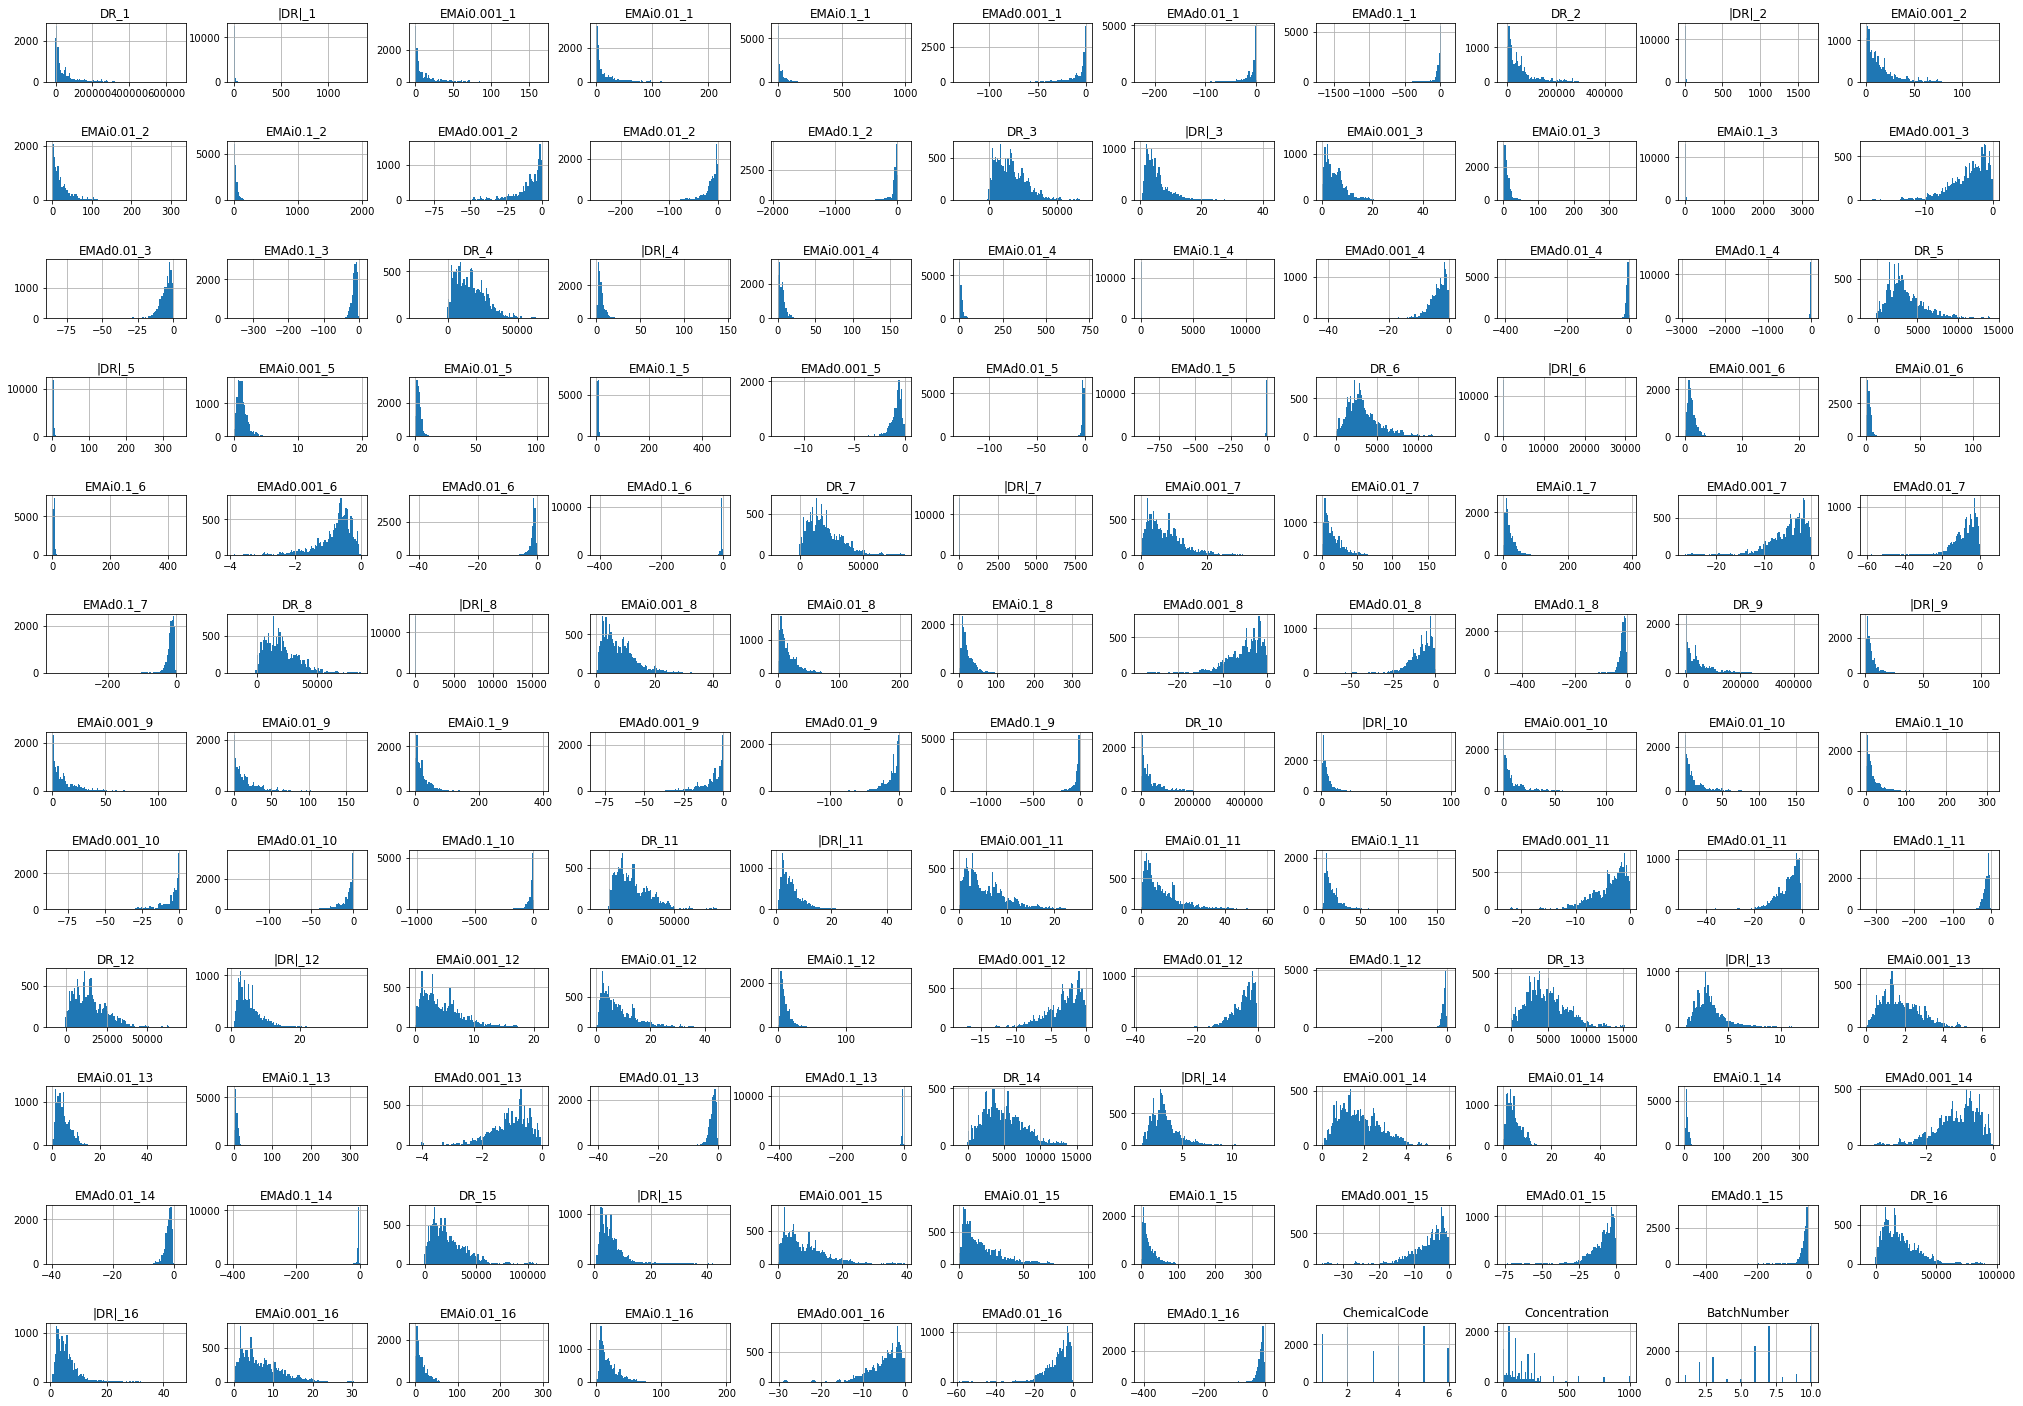

In [4]:
#Histogram of the raw data values
s_data.hist(figsize=(35,25), bins=100);
plt.subplots_adjust(hspace=1);

So there are definitely a couple of extreme outliers based on the skeweness of some of the independent variable histograms (i.e. EMAd0.1_13). At this point we do not know if those outliers are a cause of the variation in chemical and concentration or if they are erroneous. Making a pair plot, or scatter plot of each combination, is too difficult to show concisely with the number of variables we have since it would be 8,256 individual plots. Based on the previous analysis we already know that using the IQR to identify outliers is not helpful, results in 19% of the rows having at least one extreme outlier (minimum of 2643 data points based on table length of 13910). Instead lets standardize the data and specify a sigma value cutoff.

First let's determine what sigma value would be best for identifying the extreme data points that could be erroneous by looking at the number of datapoints with a Z score > than the threshold. We technically should be able to calculate the number of points since a standard deviation is related to a percentage of area under the curve, but our data is not normally distributed. The alternative would be trying to fit our data to a non-normal distribution and somehow check the fit or alternatively do a kernal density distribution and look at the points with a probability less than a specified threshold.

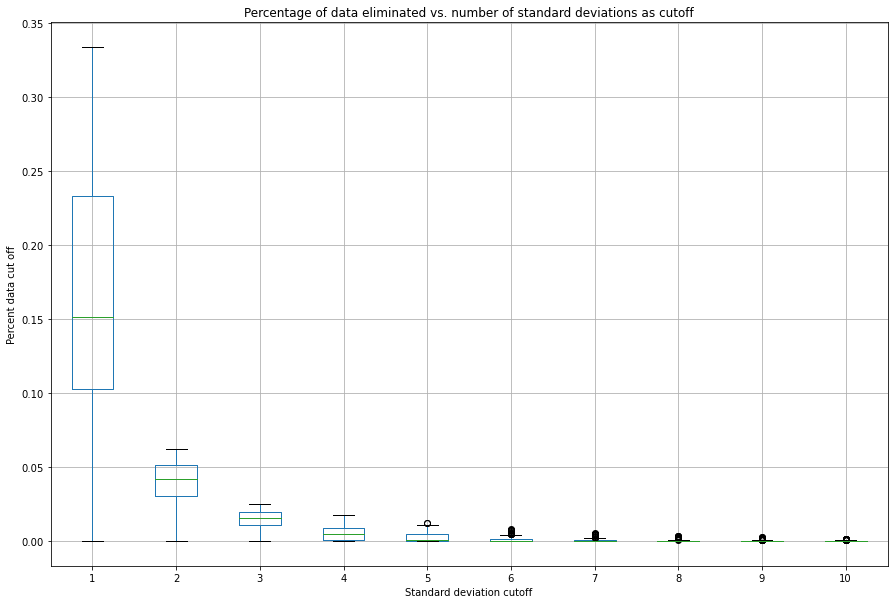

In [5]:
ind_vars = s_data.drop(columns=['ChemicalCode', 'Concentration', 'BatchNumber']).columns #column names of the independent variables
iv_df = s_data[ind_vars] #independent variable dataset
scaled_iv_df = pd.DataFrame(StandardScaler().fit_transform(iv_df), columns= iv_df.columns)

#look at how our choice of cutoff value effects the percent of points eliminated
eliminated = {} #dictionary of points eliminated per column
for s in range(1,11):
    pct_eliminated = []
    for c in scaled_iv_df.columns:
        reduced_col = scaled_iv_df[c][abs(scaled_iv_df[c]) < s] #reduced data series based on # standard deviations
        #calculate the percentage of points that would be eliminated using the current value as a threshold
        pct_eliminated.append((len(scaled_iv_df) - len(reduced_col)) / len(scaled_iv_df))
        
    eliminated[s] = pct_eliminated

eliminated = pd.DataFrame(eliminated)
eliminated.boxplot(figsize=(15,10))
plt.ylabel('Percent data cut off')
plt.xlabel('Standard deviation cutoff')
plt.title('Percentage of data eliminated vs. number of standard deviations as cutoff');

Based on the distribution of outlier points per cutoff value, for our scenario we could probably should make the cutoff at either 5 or 6 sigma. Seeing outliers points on the bar graphs indicates to me that some of the variables have no outliers using this cutoff and it is a strong assumption that not all variables would have an erroneous data point because most likely not all sensor went bad. Also we are just identifying the outliers to explore them in greater detail.

Let's use a z-score threshold of 5 and look at the histograms of the data excluding the points within the threshold and then lets look at any possible connections between the outliers and the target variables.

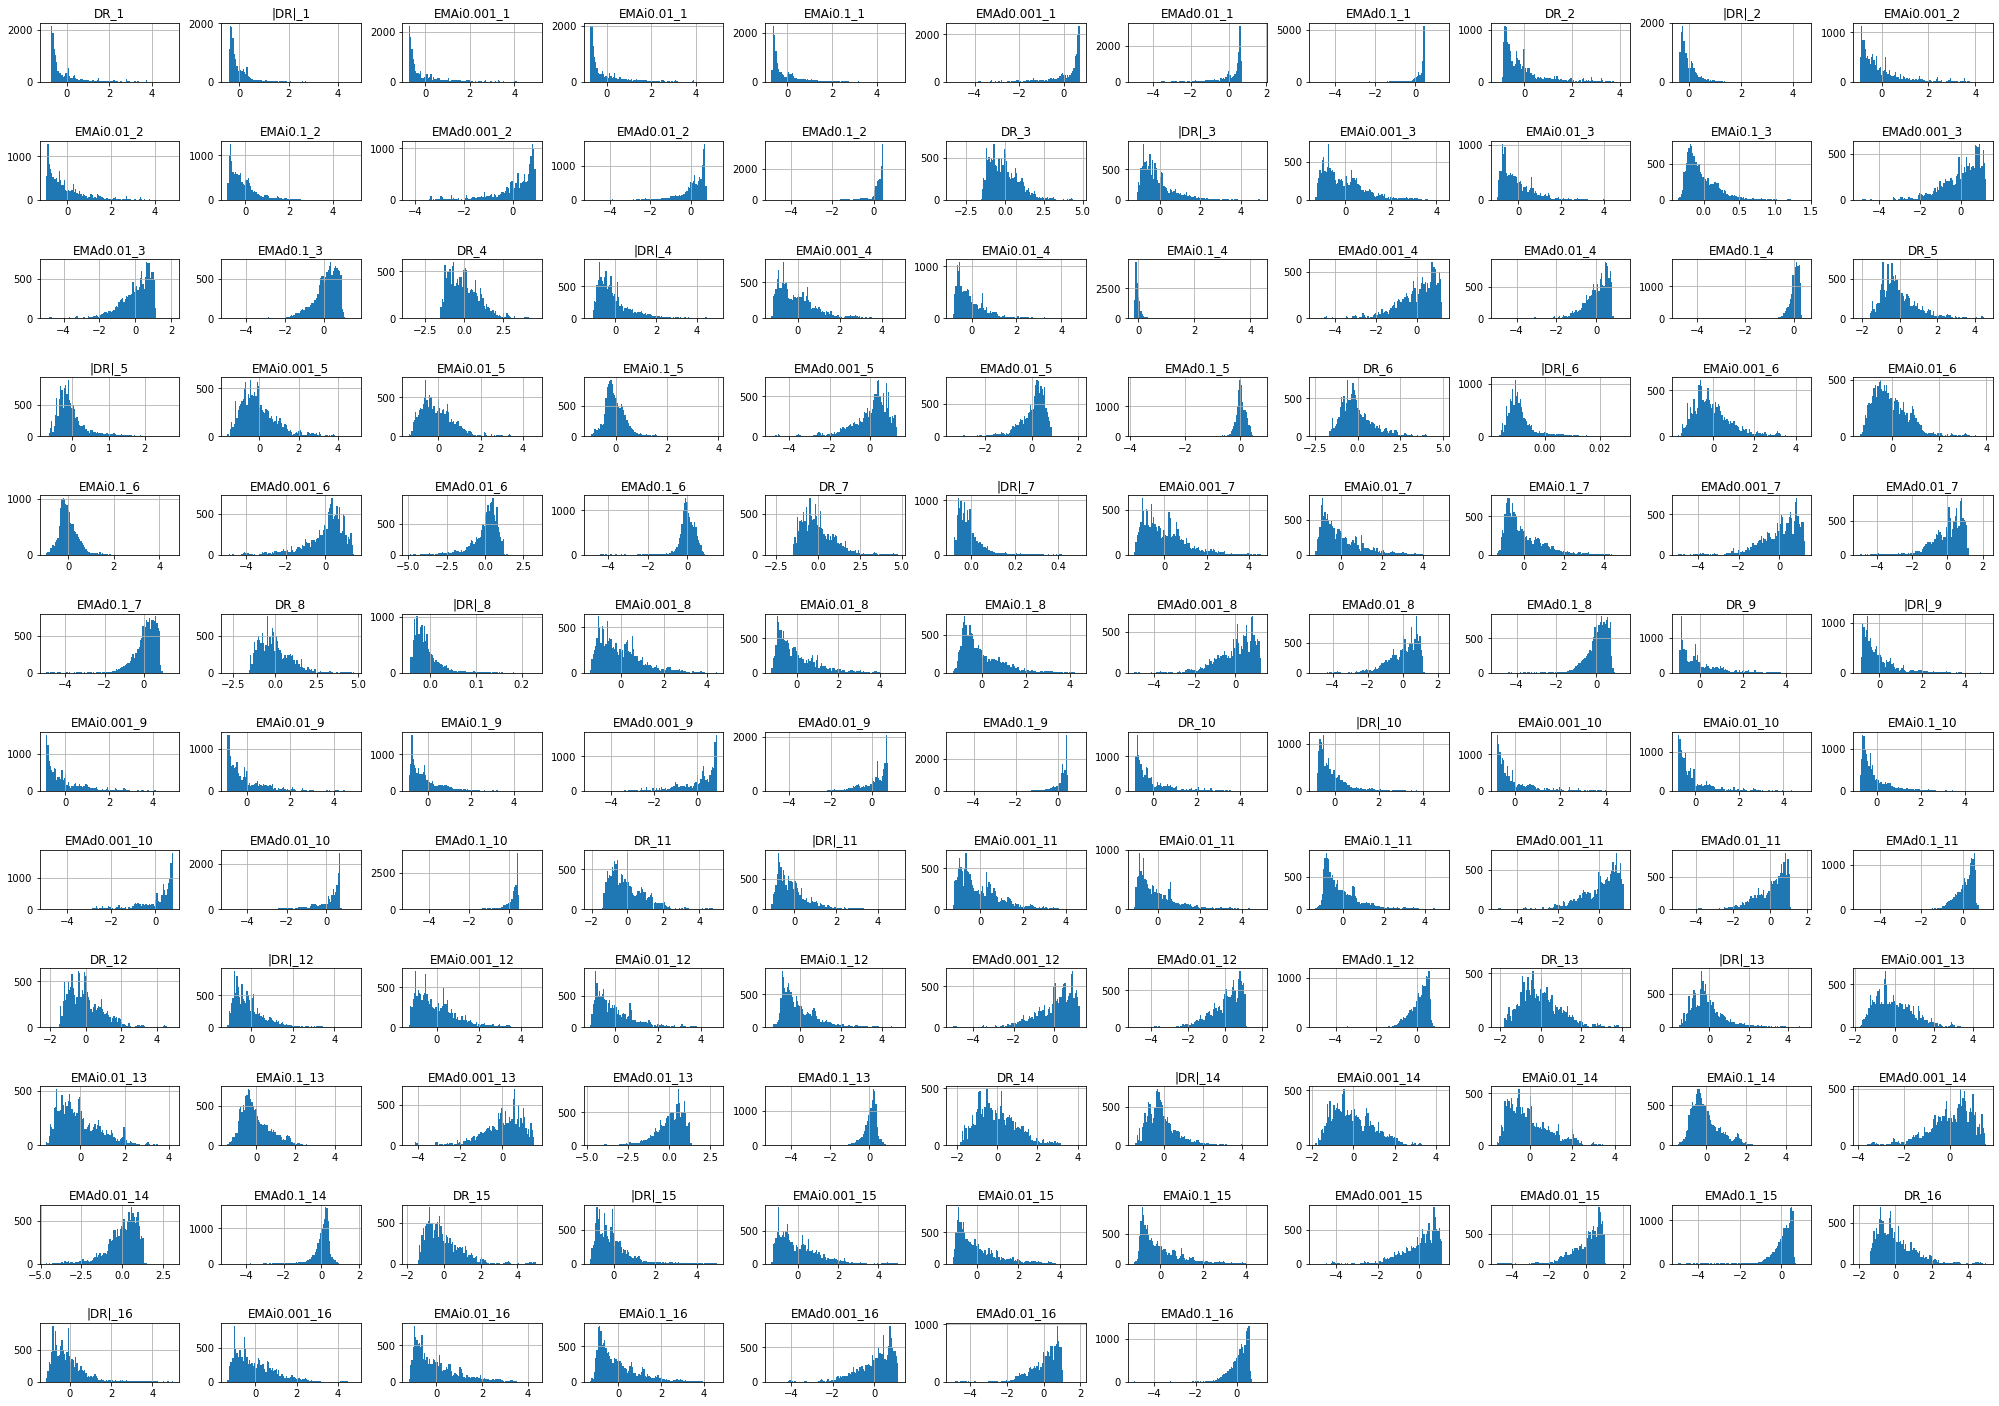

In [6]:
#Eliminate the outliers using a sigma value cutoff
no_outlier_df = pd.DataFrame()
sigma = 5 #number of standard deviatiosn to use as cutoff
for c in scaled_iv_df.columns:
    reduced_col = scaled_iv_df[c][abs(scaled_iv_df[c]) < sigma] #reduced data series based on # standard deviations
    no_outlier_df[c] = reduced_col

#plot a histogram of the log values
no_outlier_df.hist(figsize=(35,25), bins=100); 
plt.subplots_adjust(hspace=1);

1000.0    0.324952
800.0     0.127660
250.0     0.110251
100.0     0.096712
600.0     0.069632
200.0     0.058027
150.0     0.042553
300.0     0.038685
500.0     0.023211
175.0     0.015474
225.0     0.013540
50.0      0.013540
400.0     0.009671
350.0     0.009671
10.0      0.009671
450.0     0.009671
900.0     0.007737
75.0      0.005803
125.0     0.003868
275.0     0.003868
70.0      0.001934
230.0     0.001934
180.0     0.001934
Name: Concentration, dtype: float64


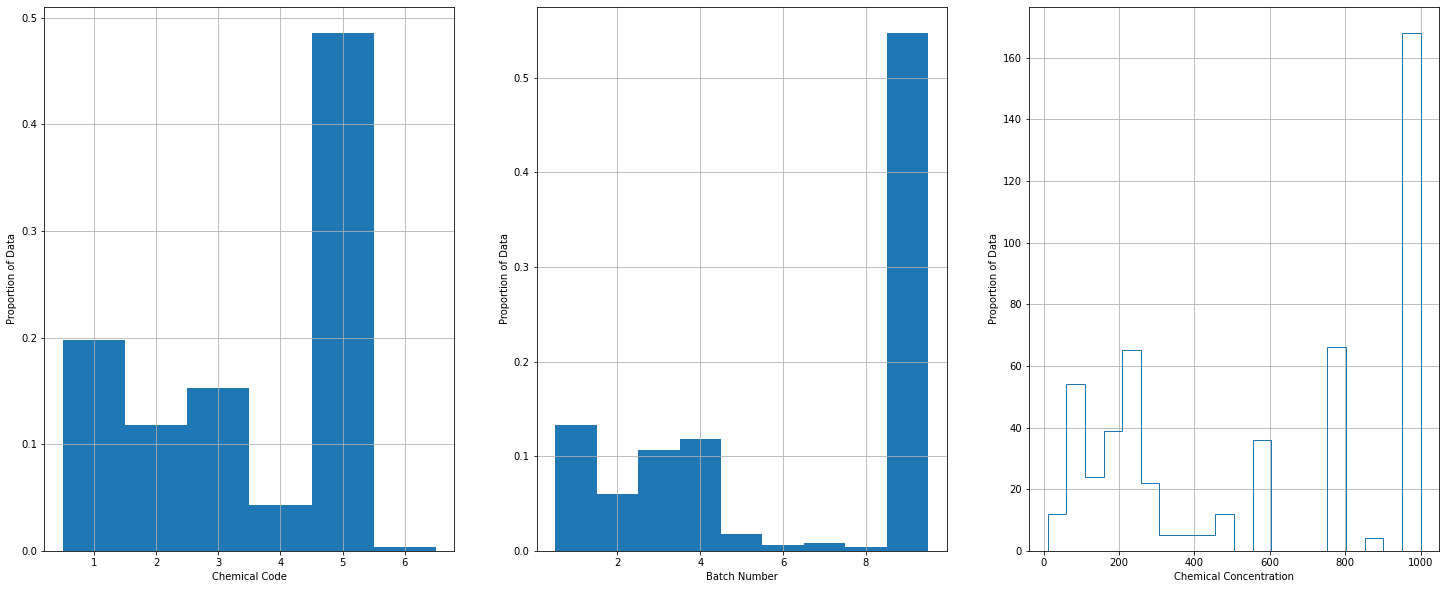

In [99]:
#Eliminate the outliers using a sigma value cutoff

sigma = 5 #number of standard deviatiosn to use as cutoff
scaled_df = pd.concat([scaled_iv_df, s_data[['ChemicalCode', 'Concentration', 'BatchNumber']]], axis=1) #combined scaled independt variable values with target variables
outlier_df = scaled_df[(abs(scaled_df[ind_vars]) > sigma).any(axis=1)] #reduced data series based on # standard deviations
print(outlier_df['Concentration'].value_counts()/len(outlier_df))

fig, ax = plt.subplots(1, 3, figsize=(25,10))

outlier_df['ChemicalCode'].hist(ax=ax[0], bins=[1,2,3,4,5,6,7], range=(0,8), density=True, align='left')
ax[0].set_xlabel('Chemical Code')
ax[0].set_ylabel('Proportion of Data')

outlier_df['BatchNumber'].hist(ax=ax[1], bins=[1,2,3,4,5,6,7,8,9,10], range=(0,11), density=True, align='left')
ax[1].set_xlabel('Batch Number')
ax[1].set_ylabel('Proportion of Data')

outlier_df['Concentration'].hist(ax=ax[2], bins=20, histtype='step')
ax[2].set_xlabel('Chemical Concentration')
ax[2].set_ylabel('Proportion of Data')

plt.show()

NOTE TO SELF: Need to consider the frequency of these occuring throughout the entire dataset and do a hypothesis test to determine if these results are significantly different. Also this assumes that these are independent of each other. in reality batch 9 could have had more runs at a higher concentration or a certain chemical that causes outliers

As of right now we have three hypotheses: 
1) Chemical 5 causes outliers  
2) Drift occurs in the sensor resulting in significantly more outliers in Batch 9  
3) Higher concentrations cause outliers, or rather the outliers are a strong response to the increase in concentration

Let's do a bootstrap analysis of the chemical concentration to determine the likelihood that the chemical concentration represents that much of the data

Number of bootstrap samples of 1000 concentration with a proportion of data > 0.32: 0


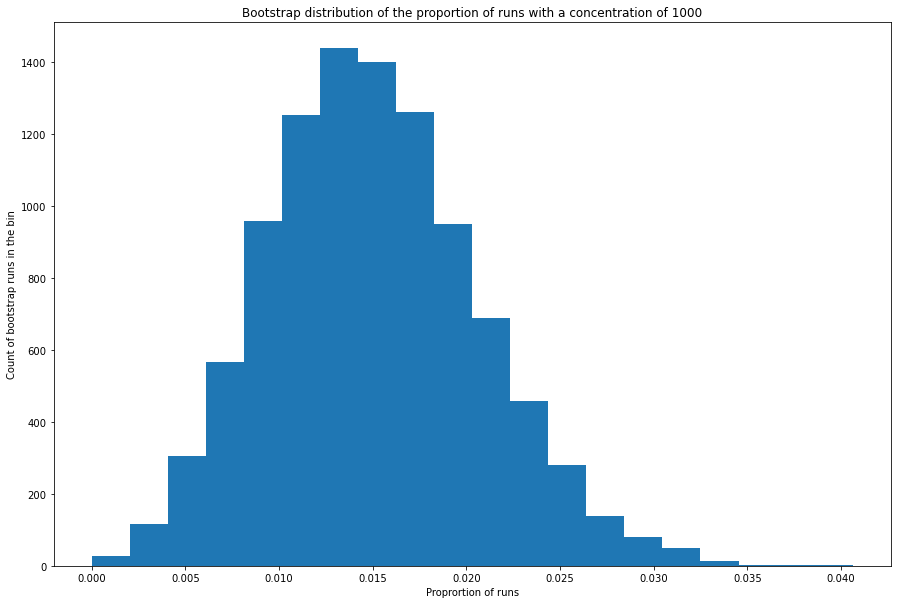

In [112]:
boot_prop_conc = []
sample_size=len(outlier_df)
conc_level = 1000
prop_conc = (outlier_df['Concentration'].value_counts()/len(outlier_df)).loc[conc_level]

for i in range(10000):
    n_level = (np.random.choice(s_data['Concentration'], replace=True, size=sample_size) == conc_level).sum() #total number of runs with a concentration equal to specified concentration choosing randomly
    boot_prop_conc.append(n_level/sample_size)

print('Number of bootstrap samples of {} concentration with a proportion of data > {}: {}'.format(conc_level, prop_conc, (boot_prop_conc > prop_conc).sum()))
fig = plt.figure(figsize=(15,10))
plt.hist(boot_prop_conc, bins=20)
plt.title('Bootstrap distribution of the proportion of runs with a concentration of 1000')
plt.xlabel('Proprortion of runs')
plt.ylabel('Count of bootstrap runs in the bin')
plt.show()

So we can conclusively say that having a higher concentration is strongly associated with the points we identified as outliers. Again excluding any sort of confounding with the other target variables. We might also want to check the other concentration levels to see if they also are over represented in the identified outliers.

In [118]:
sample_size=len(outlier_df)

for c in s_data['Concentration'].unique():
    
    boot_prop_conc = []
    try:
        prop_conc = (outlier_df['Concentration'].value_counts()/len(outlier_df)).loc[c] #proportion of outlier data at concentration level c
        for i in range(10000):
            n_level = (np.random.choice(s_data['Concentration'], replace=True, size=sample_size) == c).sum() #total number of runs with a concentration equal to specified concentration choosing randomly
            boot_prop_conc.append(n_level/sample_size) #proportion of created data with concentration equal to specified concentration
            
        if (boot_prop_conc > prop_conc).sum()/sample_size < 0.01:
            print('{} concentration is significantly over represented in the outlier data points'.format(c))
    except:
        pass

350.0 concentration is significantly over represented in the outlier data points
450.0 concentration is significantly over represented in the outlier data points
500.0 concentration is significantly over represented in the outlier data points
600.0 concentration is significantly over represented in the outlier data points
800.0 concentration is significantly over represented in the outlier data points
900.0 concentration is significantly over represented in the outlier data points
1000.0 concentration is significantly over represented in the outlier data points


So in general there seems to be a strong correlation between a higher concentration and what we have identified as an outlier. This is good news because it could mean that the data is not erroneous and is caused by a higher target variable.

Next lets see if batch number 9 is over represented in the outlier dataset and if so is it because that batch happened to have more high concentration runs?

The histogram plots show many variables with one bin that is very large and then a lot of blank space. let's try taking the log of each independent variable and see if it looks more normally distributed. However, some of the values are less than 0 so we need to scale the data first to be between >0 and 1. Below the data is scaled to be between 1 and 2 before taking the log based 10 value.

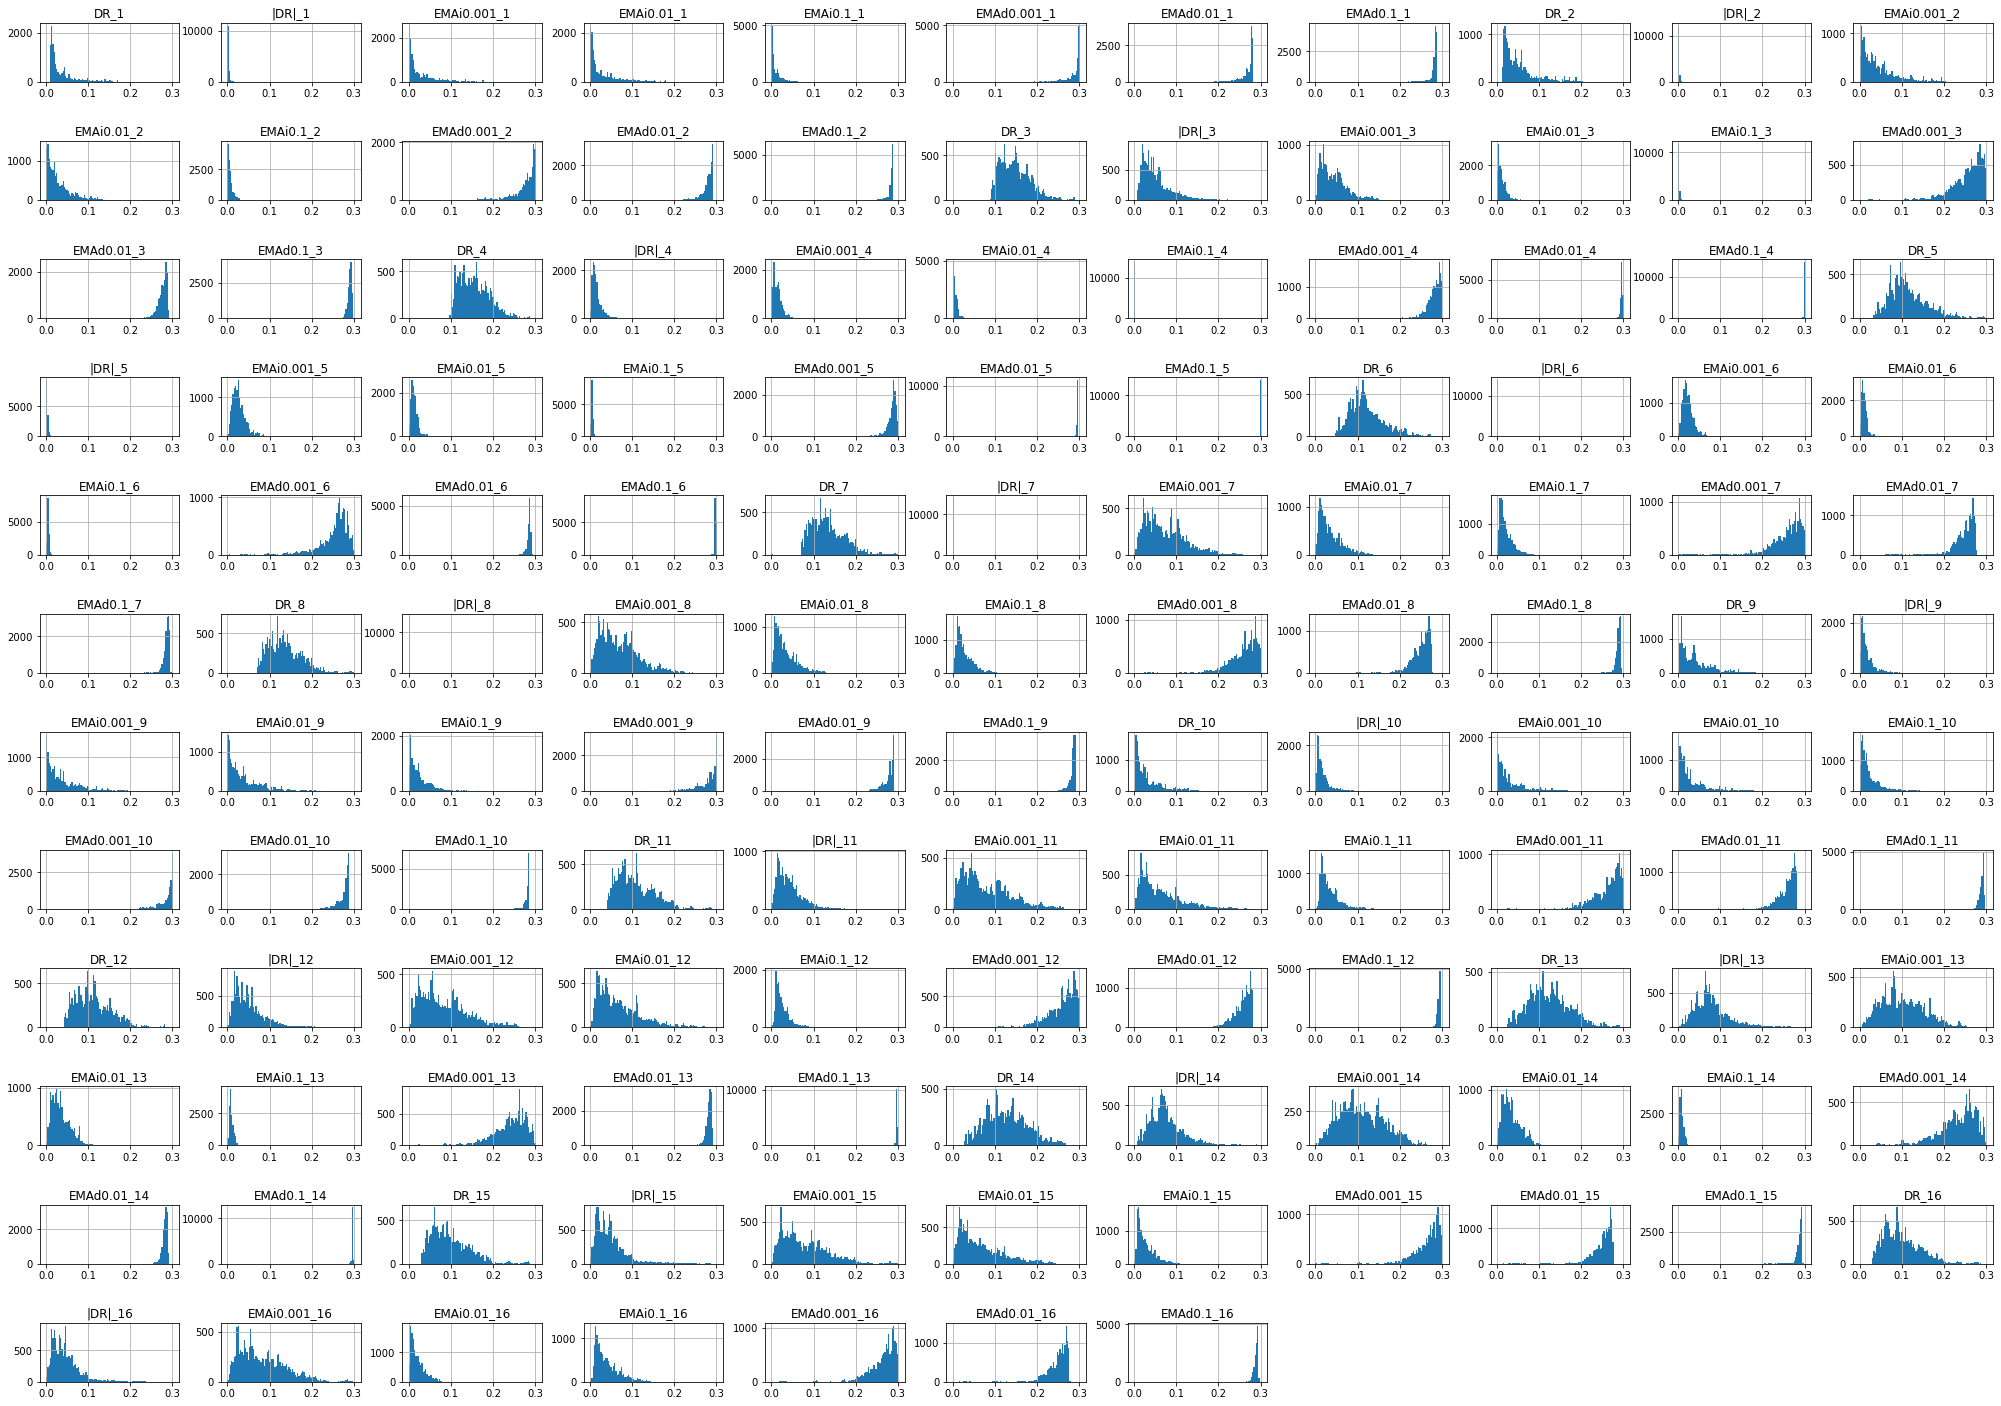

In [5]:
ind_vars = s_data.drop(columns=['ChemicalCode', 'Concentration', 'BatchNumber']).columns #column names of the independent variables
iv_df = s_data[ind_vars] #independent variable dataset
norm_iv_df = (iv_df-iv_df.min())/(iv_df.max()-iv_df.min()) + 1 #normalize the data to be between 1 and 2 so we can take the log of it
log_iv_df = np.log10(norm_iv_df) #take the log base 10 of the values to minimize the impact of the outliers

#histogram of the log of the scaled and biased data
log_iv_df.hist(figsize=(35,25), bins=100); 
plt.subplots_adjust(hspace=1);

Nevermind taking the log did not seem to work and the data is still srongly skewed so the distribution is something different from being exponential. Expected to pull the extreme values in closer to the mean values, the outlier values must be so extreeme that they need to be pulled in further than taking the log base 10 of the values.  

let's look at trying to eliminate the outlying values using its z score such that values with really low probabilities are removed from the data set for visualization purposes. first lets determine the optimal number of standard deviations that balances loss of data and readability of the diagram. Second lets eliminate/ set aside all data points that have a z score greater than the chosen threshold and plot the updated histograms.

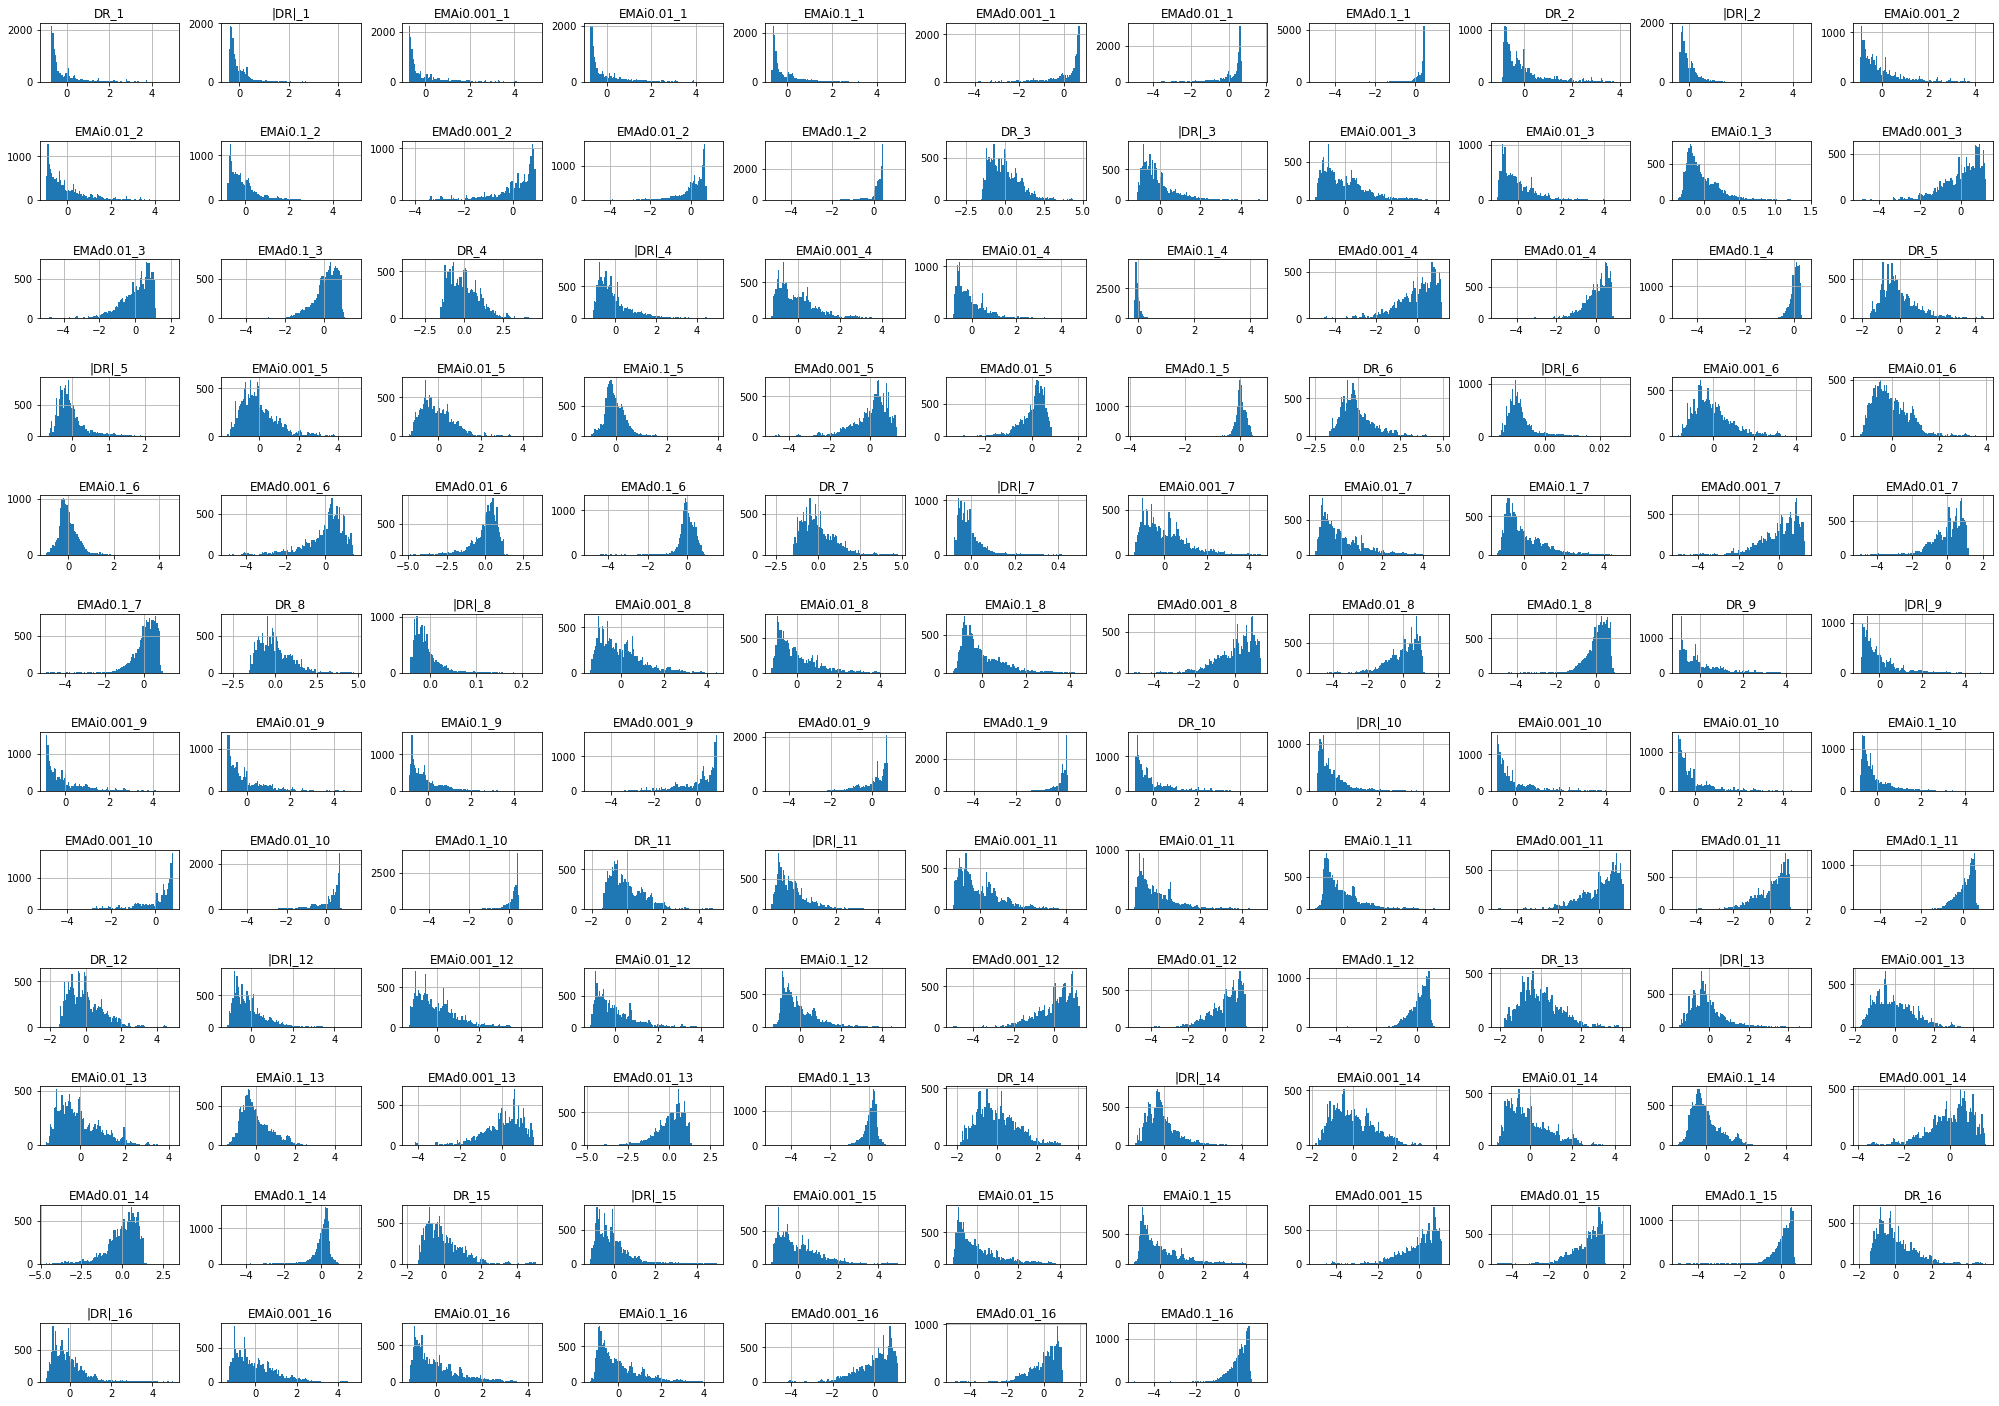

In [7]:
#Eliminate the outliers using a sigma value cutoff
no_outlier_df = pd.DataFrame()
sigma = 5 #number of standard deviatiosn to use as cutoff
for c in scaled_iv_df.columns:
    reduced_col = scaled_iv_df[c][abs(scaled_iv_df[c]) < sigma] #reduced data series based on # standard deviations
    no_outlier_df[c] = reduced_col

#plot a histogram of the log values
no_outlier_df.hist(figsize=(35,25), bins=100); 
plt.subplots_adjust(hspace=1);

Overall we can see what the actual distributions look like a lot better and we got rid of the single bin distributions that we were seeing earlier before transforming the data.

let's try normalizing on the concentration to see if that helps since the values should have some sort of response to the concentration

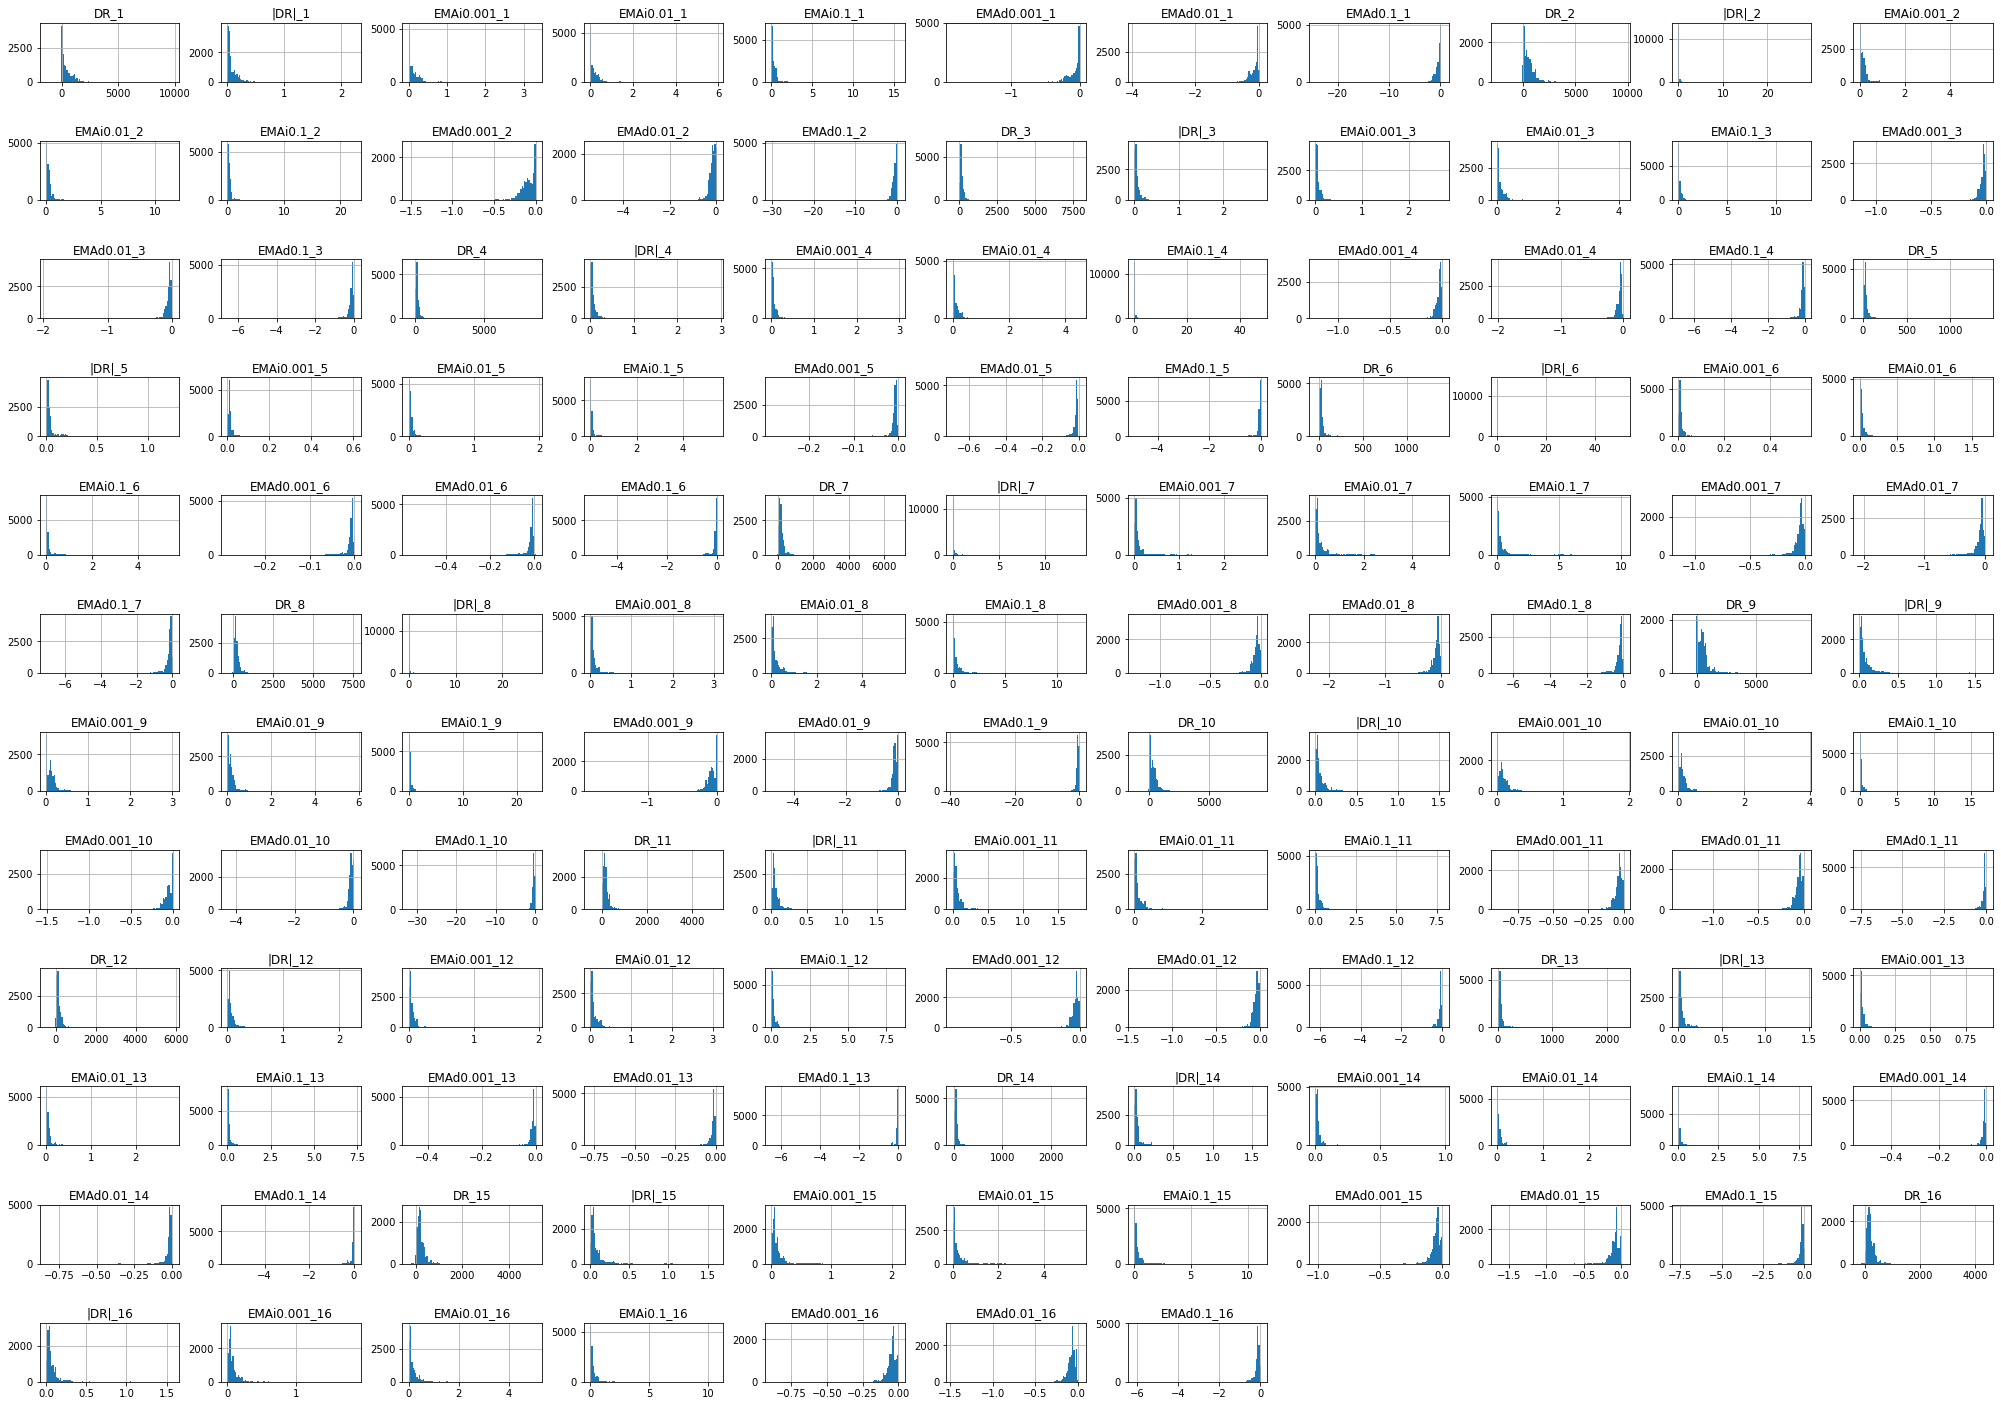

In [8]:
norm_iv_df = iv_df.divide(s_data['Concentration'], axis=0)

#plot a histogram of the log values
norm_iv_df.hist(figsize=(35,25), bins=100); 
plt.subplots_adjust(hspace=1);

Normalizing based on concentration seemed to create additional white space. most likely the case because we did a linear transform and many of the values are exponentially related to concentration?

In [13]:
tsne_feats = TSNE(learning_rate=50, n_components=3).fit_transform(scaled_iv_df)


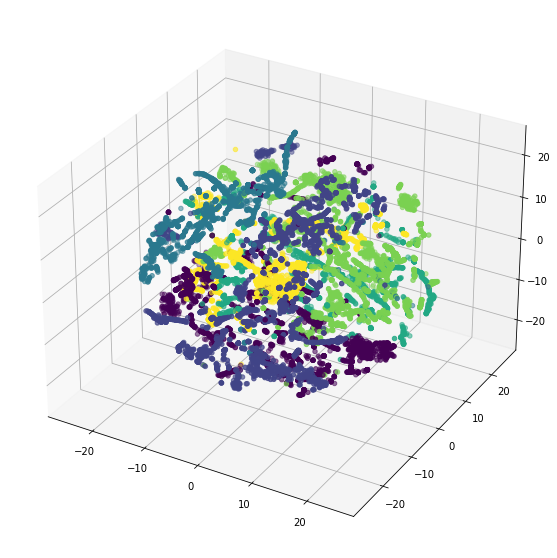

In [14]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(projection='3d')
ax.scatter(tsne_feats[:,0], tsne_feats[:,1], tsne_feats[:,2], c=s_data['ChemicalCode'])

## Break the data into sub-groups based on the element

There are 128 independent variables which means there is high dimensionality. let's look at a correlation matrix to see if any of the independent variables are highly correlated.

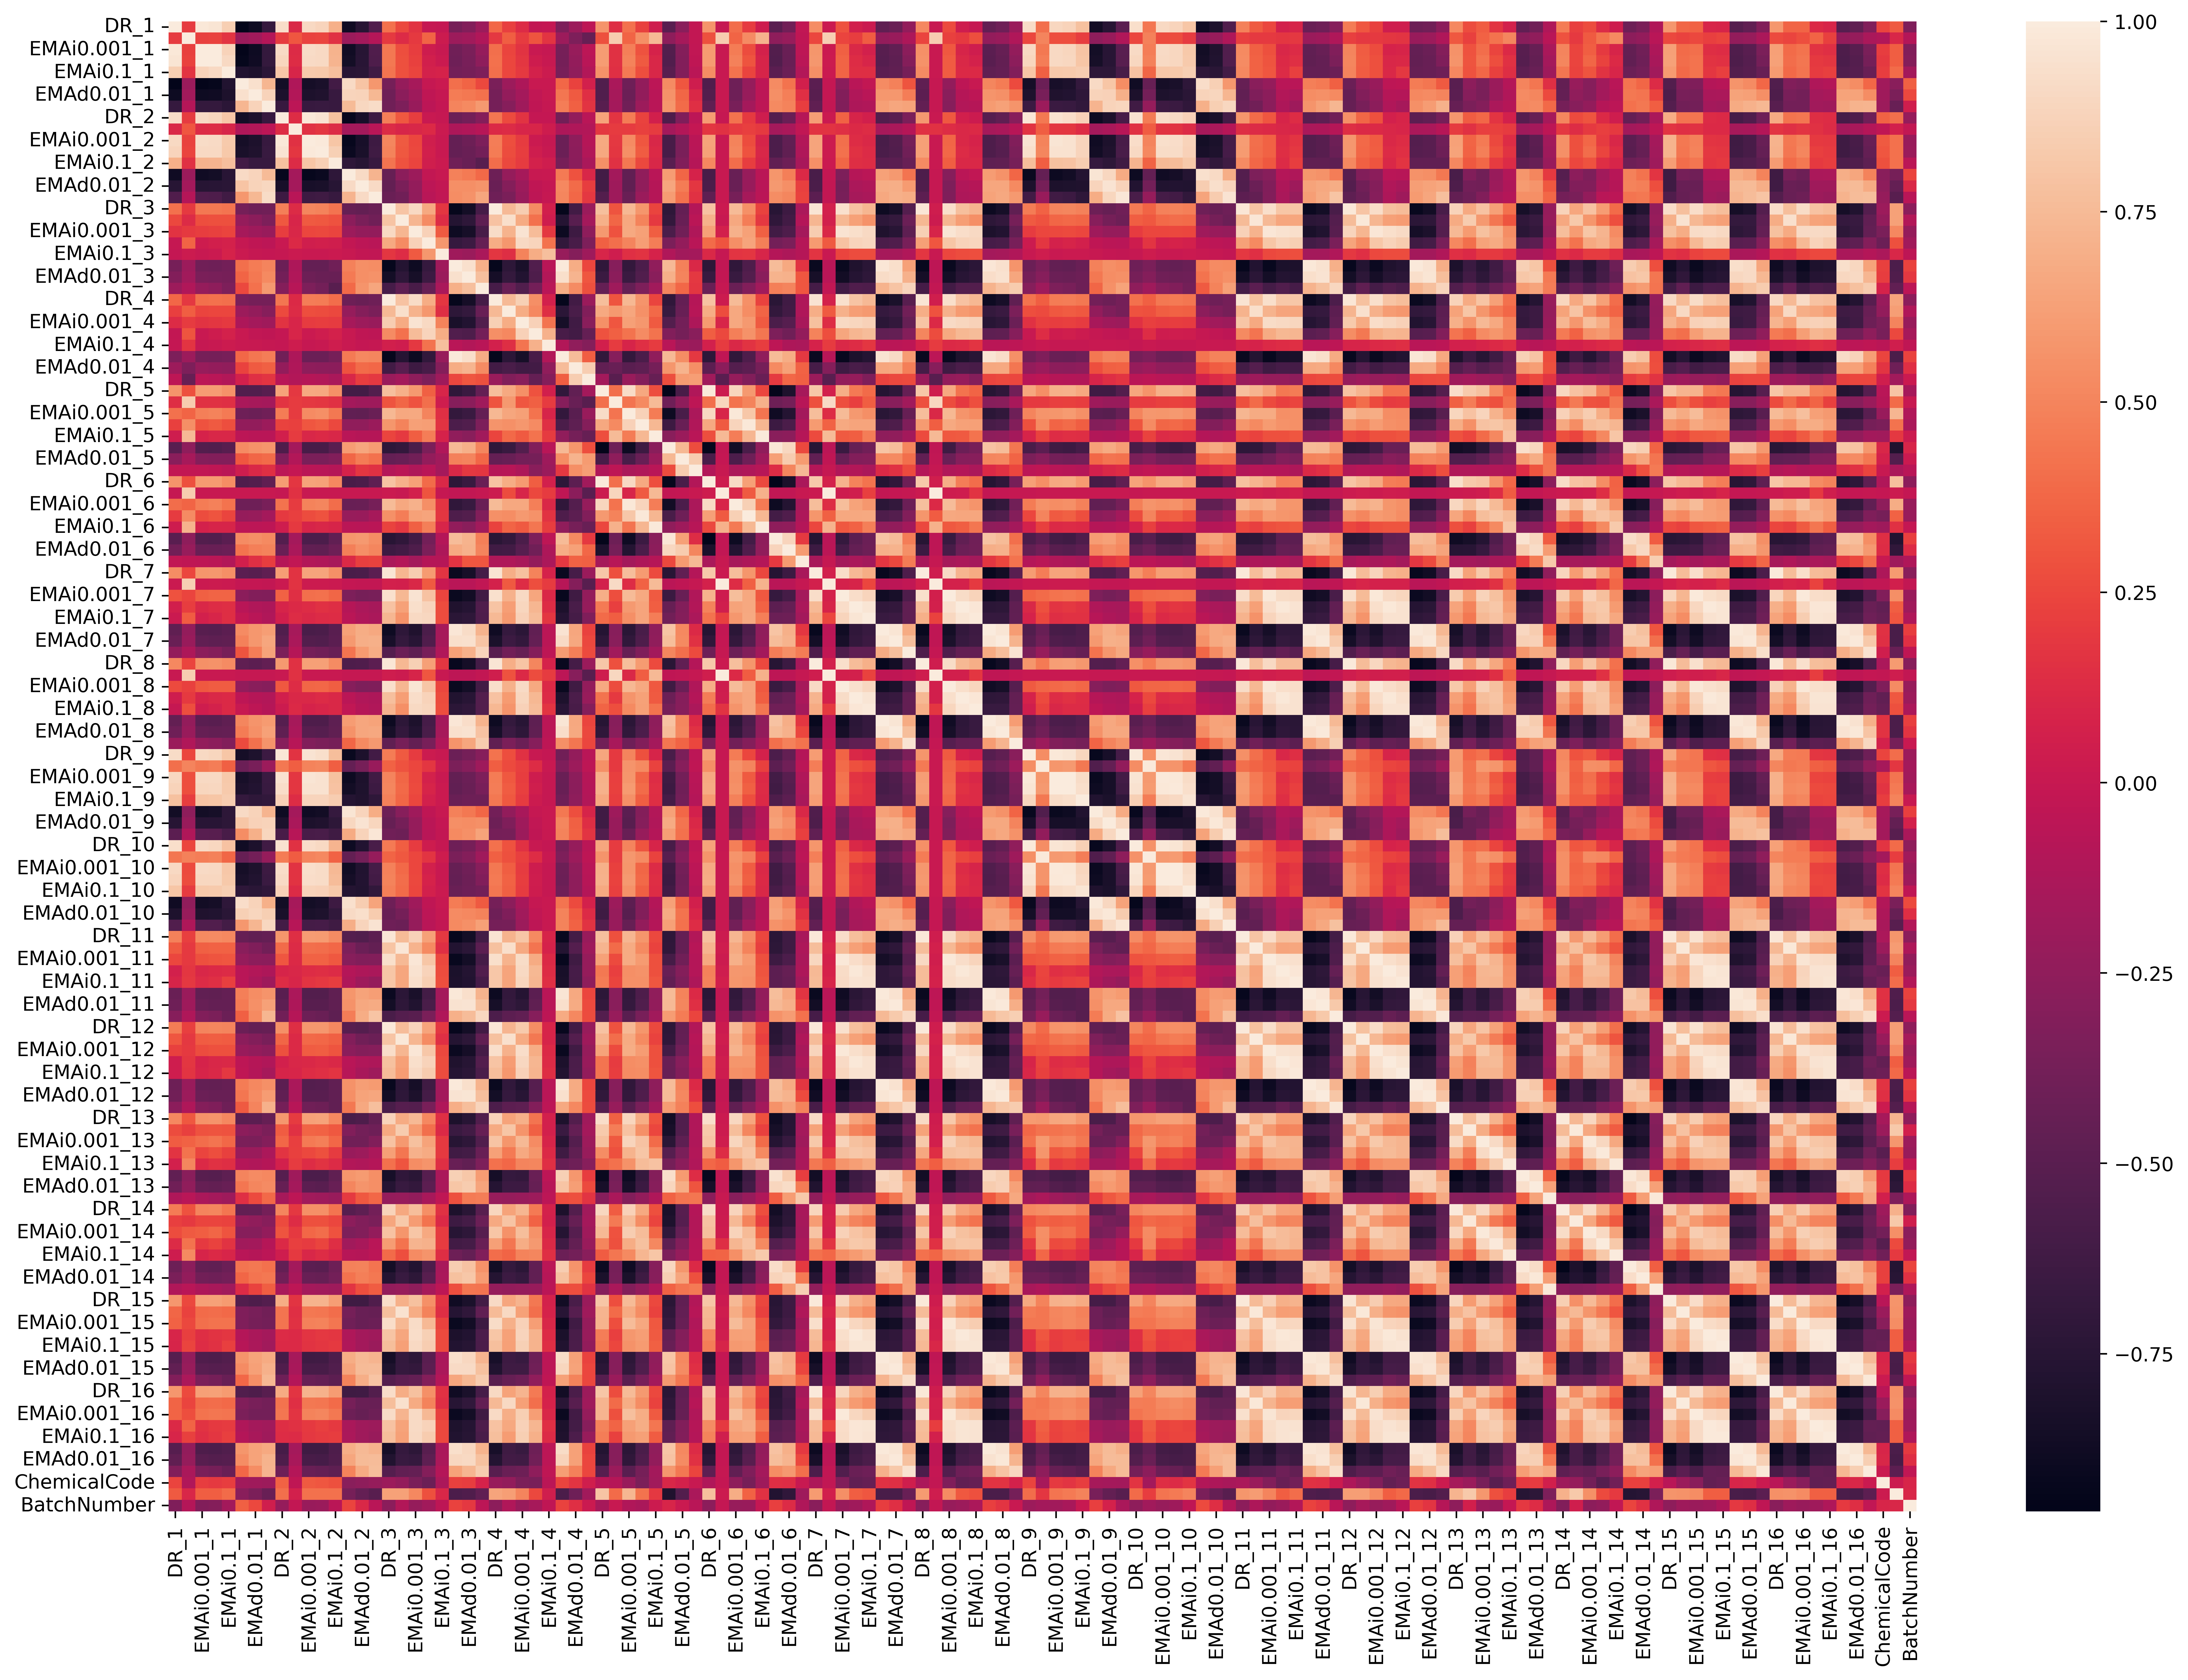

In [26]:
#lets first look at a correlation matrix
fig = plt.figure(figsize=(20,14), dpi=500)
sns.heatmap(s_data.corr());

Looks like there is large number of variables that are highly (either positively or negatively) correlated to each other meaning we should be able to reduce the number of independent variables we use without too much of the explained variance of the dataset.

Out of curiosity, let's examine if any variables are highly correlated to the chemical code.

In [27]:
chem_corr = s_data.corr()['ChemicalCode']
chem_corr.drop(index=['ChemicalCode', 'BatchNumber', 'Concentration'], inplace=True) #eliminate the dependent variables
chem_corr[abs(chem_corr) > .5]

EMAi0.01_13   -0.500287
EMAi0.01_14   -0.513988
Name: ChemicalCode, dtype: float64

so only two variables have correlation coefficient greater than 0.5 with respect to the chemical code. let's create a scatter plot of these two variables with the data points colored based on the chemical code.

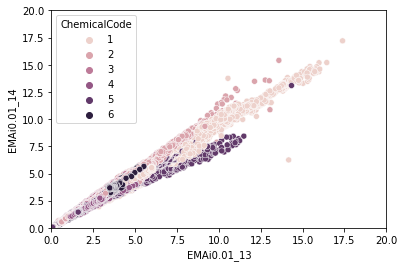

In [28]:
sns.scatterplot(x='EMAi0.01_13', y='EMAi0.01_14', data=s_data, hue='ChemicalCode');
plt.xlim([0, 20]); #do not show the two outliers
plt.ylim([0, 20]); #do not show the two outliers

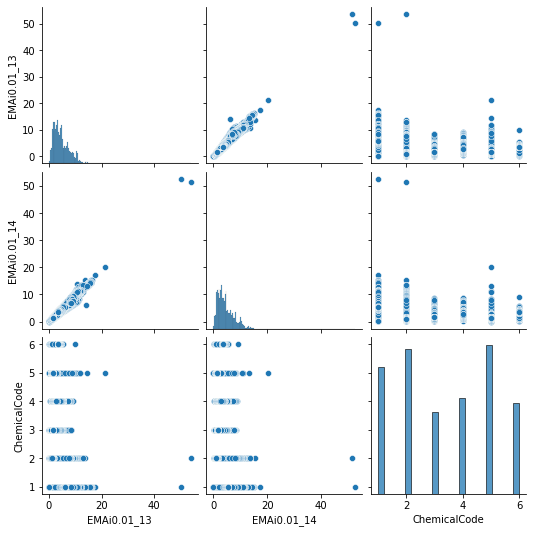

In [6]:
sns.pairplot(s_data[['EMAi0.01_13', 'EMAi0.01_14', 'ChemicalCode']]);

it doesn't look like we are as lucky as we thought because these two variables are not sufficient to determine the chemical code. The distributions at each chemical code overlap each other significantly.
One thing to note is that there seem to be two major outliers, which might be erroneous data

Ok lets see if the concentration is highly correlated to any of the independent variables.

In [32]:
chem_corr = s_data.corr()['Concentration']
chem_corr.drop(index=['ChemicalCode', 'BatchNumber', 'Concentration'], inplace=True) #eliminate the dependent variables
chem_corr[abs(chem_corr) > .8]

DR_5       0.800839
|DR|_13    0.818607
|DR|_14    0.822749
Name: Concentration, dtype: float64

There are three variables that are highly correlated with the concentration. lets plot them to see if we might be able to use them to predict the concentration

In [36]:
#initalize the graph object
corr_graph = nx.Graph()

In [37]:
#create a list of columns and the number of instances of them being highly correlated to another variable to be used for our node creation
high_corr = [] #list for combinations that have a high correlation
used_cols = [c for c in s_data.columns if c not in['Concentration', 'BatchNumber', 'ChemicalCode']] #only want to look at the independent variables
corr_matrix = s_data[used_cols].corr() #Correlation matrix
for c in range(len(used_cols)-1):
    for i in range(c+1,len(used_cols)-1):
        if abs(corr_matrix.iloc[i,c]) > 0.8: #determine if it is a highly correlated combination
            high_corr.append((used_cols[c],used_cols[i])) #add the independent variable combo to the list

#corr_count = pd.DataFrame(high_corr).value_counts().to_dict() #dictionary of the independent varaibles and the number of times it was highly correlated to another variable

In [38]:
#add the nodes
ind_vars = [i[0] for i in high_corr].append([i[1] for i in high_corr])
ind_vars = pd.DataFrame(ind_vars).value_counts().to_dict()

for iv in ind_vars.keys():
    corr_graph.add_node(iv, size = ind_vars[iv])

#add the edges
for c in high_corr:
    corr_graph.add_edge(c[0], c[1])

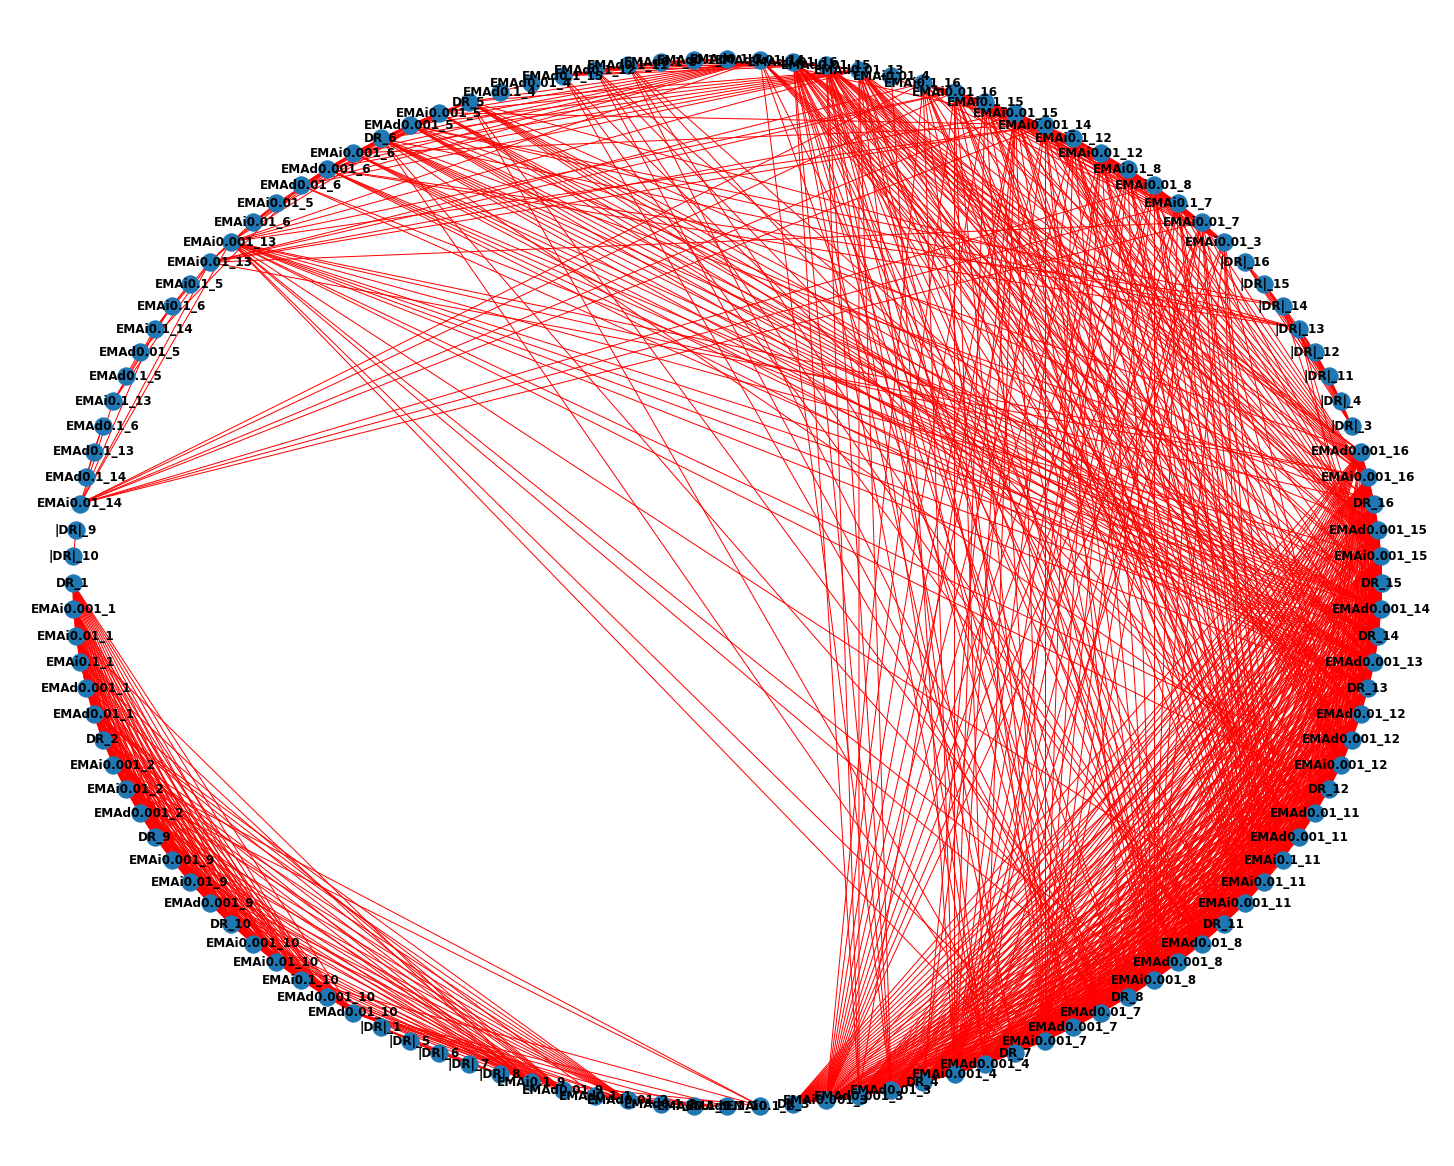

In [42]:
#draw the connections
fig = plt.figure(figsize=(20,16))
pos = nx.drawing.layout.circular_layout(corr_graph)
nx.draw_shell(corr_graph, with_labels=True, font_weight='bold', edge_color='red')

## PCA variation

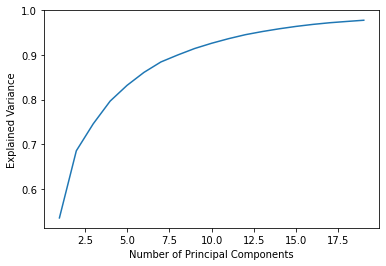

In [27]:
PCA_list =[]
for i in range(1, 20):
    PCA_model = PCA(n_components=i, random_state=12)
    exp_var = PCA_model.fit(scaled_iv_df).explained_variance_ratio_
    PCA_list.append([i,exp_var.sum()])


PCA_list = pd.DataFrame(PCA_list)
plt.plot(PCA_list[0], PCA_list[1])
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

<BarContainer object of 128 artists>

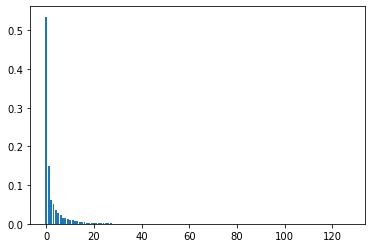

In [31]:
exp_var = PCA(random_state=12).fit(scaled_iv_df).explained_variance_ratio_
plt.bar(range(len(exp_var)), exp_var)

-- NO LONGER TRUE: combining all variables into a single variable can account for 90% of the data, with four accounting for >99%?

Now with the data standardized we get that 8 components are needed to explain 90% of the variance compared to just 1 component before. if we use significance for the cut off then we are looking for a explained variance difference of <0.05 or <0.01

In [28]:
PCA_list[1].diff()

0          NaN
1     0.150401
2     0.060458
3     0.050850
4     0.035277
5     0.029060
6     0.023333
7     0.015695
8     0.014492
9     0.011713
10    0.010263
11    0.008979
12    0.007033
13    0.006169
14    0.005358
15    0.004516
16    0.003707
17    0.002856
18    0.002700
Name: 1, dtype: float64

In [37]:
PCA_model = PCA(n_components=4, random_state=12)
PCA_transform = pd.DataFrame(PCA_model.fit_transform(s_data[used_cols]), columns=['PCA comp1' , 'PCA comp2' , 'PCA comp3', 'PCA comp4'])
PCA_transform['ChemicalCode'] = s_data['ChemicalCode']

<Figure size 1440x1440 with 0 Axes>

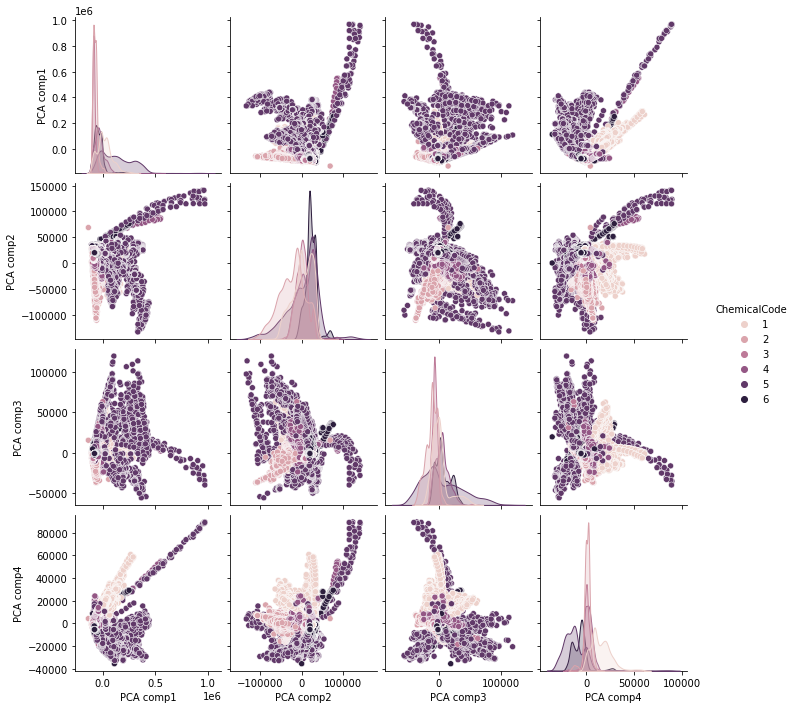

In [38]:
fig = plt.figure(figsize=(20,20))
sns.pairplot(PCA_transform, hue='ChemicalCode')
plt.show()